## Homework 3: Natural Language Processing

In [236]:
# You might need to download spacy
# import sys
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en

In [211]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import spacy
import re
import nltk
from nltk.corpus import wordnet #Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from collections import Counter 
from nltk import tokenize # fast sentence tokenization
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

# import data
df = pd.read_csv('Twitter-sentiment-self-drive-DFE.csv',encoding = 'ISO-8859-1')
df.head(20)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...
5,724227036,True,golden,241,NaN,3,1.0000,10006,3,Author is asking a question without expressing...,Will driverless cars eventually replace taxi d...
6,724227037,True,golden,226,NaN,not_relevant,0.5367,10007,not_relevant,Trains (metros) are not relevant to the focus ...,Chicago metro expected to be fully autonomous ...
7,724227038,True,golden,241,NaN,not_relevant,0.6548,10008,not_relevant,Author is not referring to self-driving cars. ...,I love the infotainment system in my new car. ...
8,724227039,True,golden,238,NaN,5,0.7187,10009,5\n4,Shows excitement that autonomous vehicles will...,Autonomous vehicles could reduce traffic fatal...
9,724227040,True,golden,230,NaN,1,0.6412,10010,2\n1,Shows fear that driverless cars will not be sa...,Driverless cars are not worth the risk. Don't...


#### 1) Perform exploratory data analysis (for example, summary statistics and histograms on the numeric fields) on the data and indicate if you foresee any problems using the data to build a model to predict sentiment. (5 points)

In [212]:
# Mentioned in guideline, to ignore the "unit_state", "sentiment_gold" and "sentiment_gold_reason fields"
# Drop irrelevant columns, such as id and time
df = df.drop(columns=['_unit_state','sentiment_gold','sentiment_gold_reason','_unit_id','_last_judgment_at','our_id'])
df

,_golden,_trusted_judgments,sentiment,sentiment:confidence,text
0,True,236,5,0.7579,Two places I'd invest all my money if I could:...
1,True,231,5,0.8775,Awesome! Google driverless cars will help the ...
2,True,233,2,0.6805,If Google maps can't keep up with road constru...
3,True,240,2,0.8820,Autonomous cars seem way overhyped given the t...
4,True,240,3,1.0000,Just saw Google self-driving car on I-34. It w...
...,...,...,...,...,...
7151,True,65,not_relevant,0.5616,Washington DC metro trains are all self-drivin...
7152,True,71,not_relevant,0.7293,I think #DARPA works on autonomous drone techn...
7153,True,63,not_relevant,0.8854,I love the idea of driving myself to the denti...
7154,True,67,not_relevant,0.8431,Who likes cars these days? No me. Too expensiv...


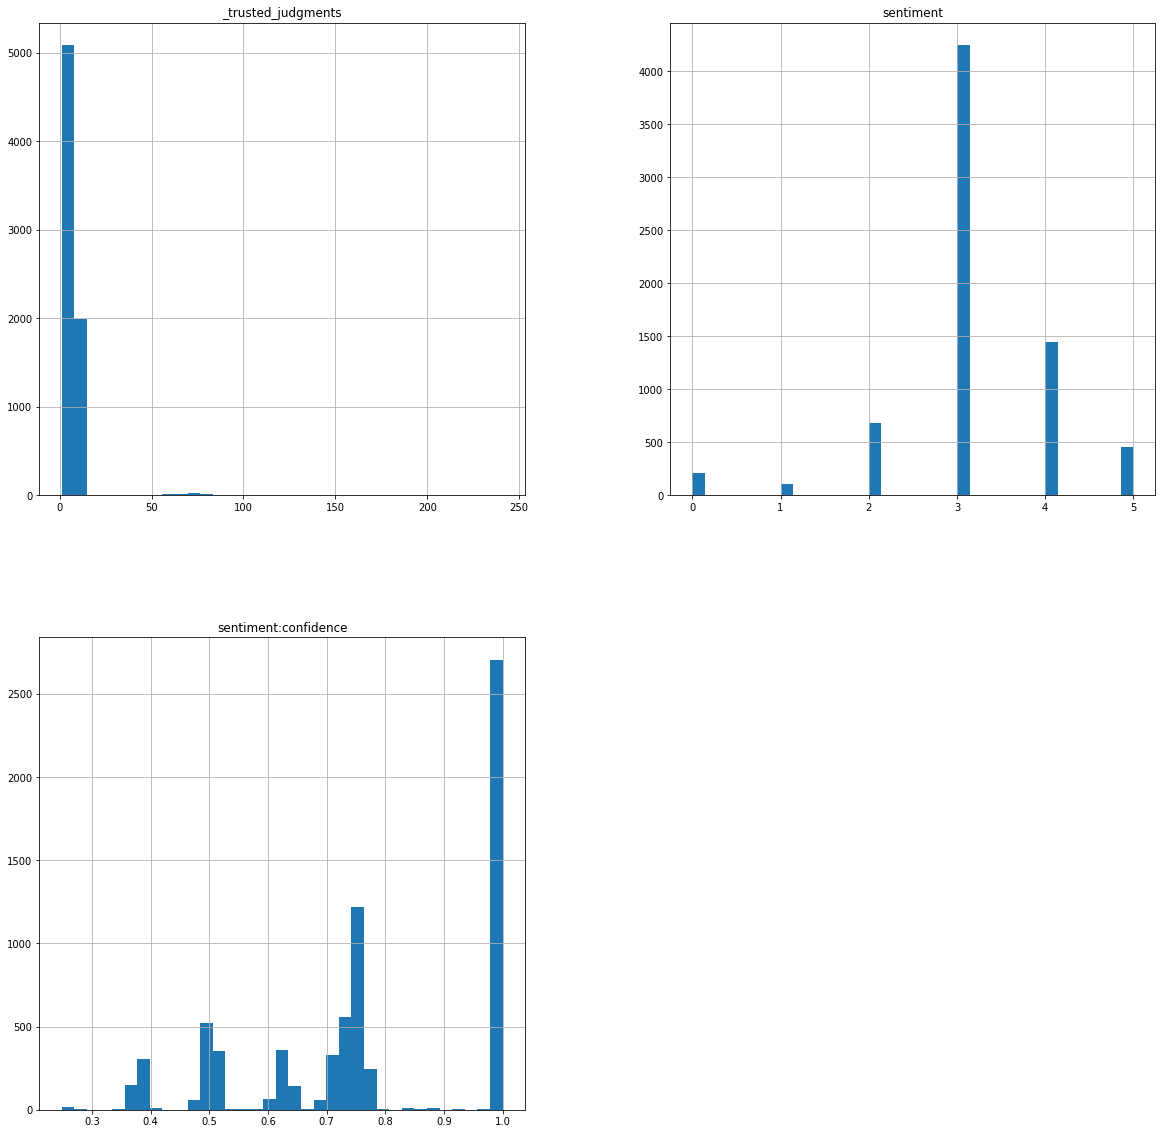

In [213]:
#histograms
#replace sentiment no_relevant as 0 for histogram
df_histogram = df.copy()
df_histogram["sentiment"].replace('not_relevant', '0',inplace=True)
df_histogram["sentiment"] = df_histogram["sentiment"].astype(int)
df_histogram.hist(figsize=(20, 20), bins = 35) 
plt.show()

In [214]:
#statistics
df_histogram.describe()

,_trusted_judgments,sentiment,sentiment:confidence
count,7156.000000,7156.000000,7156.000000
mean,5.834405,3.114310,0.774654
std,11.144930,0.933011,0.205363
min,1.000000,0.000000,0.248000
25%,3.000000,3.000000,0.630600
50%,4.000000,3.000000,0.753100
75%,8.000000,4.000000,1.000000
max,241.000000,5.000000,1.000000


In [215]:
df_histogram.isnull().sum()

_golden                 0
_trusted_judgments      0
sentiment               0
sentiment:confidence    0
text                    0
dtype: int64

All texts are non-null values. Only data in "_last_judgment_at" column are partially null.

#### 2) Tokenize the Tweets for analysis. Show the most common words/tokens overall, nouns, adjectives for all of the tweets. You should exclude stopwords and the frequent words/phrases like “self-driving cars” that do not help in the prediction task. (Note: if you decide to stem or lemmatize the words for modeling in the following step, which is recommended, you should do that after the part of speech tagging in this step.) (5 points)

In [216]:
# Tokenization
tknzr = TweetTokenizer()
text = df['text']
nlp = spacy.load("en_core_web_sm")
# preprocess texts with NTLK's TweetTokenizer
cleaned_tweets = []
cleaned_tweetsline = []
t_tokenizer = TweetTokenizer()

# preprocess punctuation 
# reference: https://blog.csdn.net/Diobld/article/details/123585196
punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！《》【】（）、。：；’‘……￥·"""
dicts={i:'' for i in punctuation}
punc_table=str.maketrans(dicts)

#exclude stopwords and frequent words/phrases like “self-driving cars”
for t in text:
  #remove hyperlinks
  t = re.sub(r"https?://\S+", "", t)
  #remove punctuation 
  t = t.translate(punc_table)
  #regular expression for words
  t = re.sub(r"[^A-Za-z\s]+", "", t)
  #frequent words list (not help in the prediction task) 
  # t = re.sub(r"self-driving|cars|drive|driverless", "", t)
  frequentwordslist = ["self", "driving","car","selfdrivingcars","drive","ces","autonomous","google"]

  #tokenize
  cleaned = [word for word in t_tokenizer.tokenize(t.lower())  if word.isalpha() and word not in nlp.Defaults.stop_words and (len(word) > 2) and (not any(fw in word for fw in frequentwordslist))]
  cleaned_tweets.append(cleaned)
  cleaned_tweetsline.append(' '.join(cleaned))
cleaned_tweets

[['invest', 'money', 'printing'],
 ['awesome', 'help', 'blind', 'travel'],
 ['maps', 'cant', 'road', 'construction', 'supposed', 'trust'],
 ['way',
  'overhyped',
  'given',
  'technology',
  'challenges',
  'pilotless',
  'planes',
  'doable',
  'needed'],
 ['saw', 'painted', 'green', 'blue'],
 ['eventually', 'replace', 'taxi', 'cities'],
 ['chicago', 'metro', 'expected', 'fully'],
 ['love', 'infotainment', 'system', 'new', 'thing'],
 ['vehicles', 'reduce', 'traffic', 'fatalities'],
 ['worth',
  'risk',
  'dont',
  'want',
  'highway',
  'server',
  'crashes',
  'sadmacface',
  'bluescreenofdeath'],
 ['legal', 'florida', 'california', 'michigan'],
 ['audi', 'license', 'nevada', 'dmv', 'test', 'automated', 'vehicles', 'audi'],
 ['audi',
  'says',
  'manufacturer',
  'world',
  'license',
  'nevada',
  'dmv',
  'test',
  'vehicles',
  'doesnt'],
 ['future', 'buying', 'cnet', 'audi', 'ready', 'test', 'public', 'roads'],
 ['audi', 'test', 'tampa', 'today', 'pretty', 'cool'],
 ['audi', 'au

Answer of the most common words/tokens: Overall, top 30

---



In [217]:
# The most common words/tokens: Overall, top 30
#count hashtag function
count_hashtag = Counter()
for i in range(len(cleaned_tweets)):
  for j in range(len(cleaned_tweets[i])):
    if len(cleaned_tweets[i][j]) > 2:
      count_hashtag[cleaned_tweets[i][j]] += 1

text_hashtags = []
text_hashtags_counts = []
for k, v in count_hashtag.most_common(30):
  text_hashtags.append(k)
  text_hashtags_counts.append(v)
print("The most common words/tokens: Overall, top 30")
print(text_hashtags)

The most common words/tokens: Overall, top 30
['future', 'saw', 'like', 'uber', 'new', 'vehicle', 'california', 'need', 'think', 'cant', 'want', 'amp', 'road', 'vehicles', 'people', 'today', 'wheel', 'technology', 'tech', 'going', 'dont', 'time', 'cool', 'way', 'steering', 'wait', 'says', 'look', 'soon', 'years']


In [218]:
# speech tagging
# create lists of POS occurrences (adjectives, nouns, verbs)
adjs = []
nouns = []
verbs = []
for i in range(len(cleaned_tweetsline)):
  for token in nlp(cleaned_tweetsline[i]):
    if token.pos_ == 'ADJ':
      adjs.append(token.text)
    elif token.pos_ == 'NOUN':
      nouns.append(token.text)
    elif token.pos_ == 'VERB':
      verbs.append(token.text)

In [219]:
# define counter function
def top_counter(pos):
  pos_counter = Counter()
  pos_counter.update(pos)
  return pos_counter  

In [220]:
#define finding common words function
def common_words (counter,time):
  text_hashtags = []
  text_hashtags_counts = []
  for k, v in counter.most_common(time):
    text_hashtags.append(k)
    text_hashtags_counts.append(v)
  return text_hashtags

Answer of the most common words/tokens: Nouns, top 30

In [221]:
# Lemmatization
lm = nltk.stem.wordnet.WordNetLemmatizer()
nouns_lemm = []
for n in nouns:
  lmword = lm.lemmatize(word = n,pos = wordnet.NOUN)
  if len(lmword) > 1:
    nouns_lemm.append(lmword)
# The most common words/tokens: Nouns, top 30
noun_counter = top_counter(nouns_lemm)
print("The most common words/tokens: Nouns, top 30")
print(common_words(noun_counter, 30))

The most common words/tokens: Nouns, top 30
['vehicle', 'road', 'street', 'today', 'people', 'year', 'wheel', 'technology', 'time', 'uber', 'way', 'city', 'future', 'thing', 'amp', 'tech', 'view', 'traffic', 'day', 'robot', 'accident', 'world', 'auto', 'work', 'glass', 'video', 'steering', 'test', 'apple', 'ride']


Answer of the most common words/tokens: Adjectives, top 30

In [222]:
# Lemmatization
adjs_lemm = []
for n in adjs:
  lmword = lm.lemmatize(word = n,pos = wordnet.ADJ)
  if len(lmword) > 1:
    adjs_lemm.append(lmword)
# The most common words/tokens: Adjectives, top 30
adj_counter = top_counter(adjs_lemm)
print("The most common words/tokens: Adjectives, top 30")
print(common_words(adj_counter, 30))

The most common words/tokens: Adjectives, top 30
['new', 'future', 'good', 'cool', 'ready', 'great', 'legal', 'public', 'interesting', 'big', 'safe', 'awesome', 'bad', 'real', 'amazing', 'human', 'right', 'smart', 'ill', 'best', 'free', 'tesla', 'close', 'little', 'electric', 'excited', 'fast', 'long', 'available', 'able']


Answer of the most common words/tokens: Verbs, top 30

In [223]:
# Lemmatization
verbs_lemm = []
for n in verbs:
  lmword = lm.lemmatize(word = n,pos = wordnet.VERB)
  if len(lmword) > 1:
    verbs_lemm.append(lmword)
# The most common words/tokens: Verbs, top 30
verb_counter = top_counter(verbs_lemm)
print("The most common words/tokens: Verbs, top 30")
print(common_words(verb_counter, 30))

The most common words/tokens: Verbs, top 30
['saw', 'think', 'want', 'look', 'need', 'come', 'go', 'say', 'get', 'wait', 'see', 'pass', 'take', 'make', 'build', 'know', 'spot', 'work', 'hit', 'buy', 'happen', 'start', 'steer', 'test', 'allow', 'automate', 'invent', 'watch', 'use', 'mean']


#### 4) Create a model to predict what sentiment a Tweet will be given on the 1-5 scale. Note that you do not have to run any sentiment analysis packages (e.g. Vader or TextBlob) to build this model, just use the features in the data (including words in the text) as predictors. What are the 10 top words/tokens for each sentiment rating? (5 points)

In [224]:
import joblib
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB

In [225]:
# some data might be not relevant to the topic, so keep "not_relevant" category for model
df_model = df.copy()
df_model['clean_text'] = cleaned_tweetsline
df_model['cleaned_word'] = cleaned_tweets
df_model

,_golden,_trusted_judgments,sentiment,sentiment:confidence,text,clean_text,cleaned_word
0,True,236,5,0.7579,Two places I'd invest all my money if I could:...,invest money printing,"[invest, money, printing]"
1,True,231,5,0.8775,Awesome! Google driverless cars will help the ...,awesome help blind travel,"[awesome, help, blind, travel]"
2,True,233,2,0.6805,If Google maps can't keep up with road constru...,maps cant road construction supposed trust,"[maps, cant, road, construction, supposed, trust]"
3,True,240,2,0.8820,Autonomous cars seem way overhyped given the t...,way overhyped given technology challenges pilo...,"[way, overhyped, given, technology, challenges..."
4,True,240,3,1.0000,Just saw Google self-driving car on I-34. It w...,saw painted green blue,"[saw, painted, green, blue]"
...,...,...,...,...,...,...,...
7151,True,65,not_relevant,0.5616,Washington DC metro trains are all self-drivin...,washington metro trains arent,"[washington, metro, trains, arent]"
7152,True,71,not_relevant,0.7293,I think #DARPA works on autonomous drone techn...,think darpa works drone technology military apps,"[think, darpa, works, drone, technology, milit..."
7153,True,63,not_relevant,0.8854,I love the idea of driving myself to the denti...,love idea dentist license month freedom,"[love, idea, dentist, license, month, freedom]"
7154,True,67,not_relevant,0.8431,Who likes cars these days? No me. Too expensiv...,likes days expensive dont need,"[likes, days, expensive, dont, need]"


In [226]:
#split data into train and test set
df_train, df_test = train_test_split(df_model, test_size=0.30, stratify=df_model.sentiment)

In [227]:
#create Bag of Words features
vec = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words="english",
)

X_train = vec.fit_transform(df_train.clean_text)
X_test = vec.transform(df_test.clean_text)

y_train = df_train.sentiment
y_test = df_test.sentiment

Train the Model

In [228]:
# train the model
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [229]:
#use model to predict sentiment (sentiment:2 case)
sample_text = ["google maps cant road construction supposed trust"]
sample_vec = vec.transform(sample_text)
nb.predict(sample_vec)

array(['2'], dtype='<U12')

In [230]:
# groupby "sentiment"
gp = df_model.groupby('sentiment')
# sentiment rating:1
gp_1 = gp.get_group("1")
# sentiment rating:2
gp_2 = gp.get_group("2")
# sentiment rating:3
gp_3 = gp.get_group("3")
# sentiment rating:4
gp_4 = gp.get_group("4")
# sentiment rating:5
gp_5 = gp.get_group("5")
# sentiment rating:not_relevant
gp_no = gp.get_group("not_relevant")

In [231]:
#define single list function
def single_list (df):
  gp_word = df["clean_text"]
  newlist = []
  for i in range(len(gp_word)):
    for token in nlp(gp_word.iloc[i]):
      newlist.append(token)
  return newlist

In [232]:
# 10 top words/tokens for each sentiment rating
# some data might be not relevant to the topic, so keep "not_relevant" category
print("Top 10 words/tokens for each sentiment rating")
counter = top_counter(single_list(gp_1))
print(f"Sentiment_1: {common_words(counter, 10)}")
counter = top_counter(single_list(gp_2))
print(f"Sentiment_2: {common_words(counter, 10)}")
counter = top_counter(single_list(gp_3))
print(f"Sentiment_3: {common_words(counter, 10)}")
counter = top_counter(single_list(gp_4))
print(f"Sentiment_4: {common_words(counter, 10)}")
counter = top_counter(single_list(gp_5))
print(f"Sentiment_5: {common_words(counter, 10)}")
counter = top_counter(single_list(gp_no))
print(f"Sentiment_not relevant: {common_words(counter, 10)}")

Top 10 words/tokens for each sentiment rating
Sentiment_1: [worth, risk, do, nt, want, highway, server, crashes, sadmacface, bluescreenofdeath]
Sentiment_2: [maps, ca, nt, road, construction, supposed, trust, way, overhyped, given]
Sentiment_3: [saw, painted, green, blue, eventually, replace, taxi, cities, legal, florida]
Sentiment_4: [future, buying, cnet, audi, ready, test, public, roads, audi, test]
Sentiment_5: [invest, money, printing, awesome, help, blind, travel, vehicles, reduce, traffic]
Sentiment_not relevant: [chicago, metro, expected, fully, love, infotainment, system, new, thing, come]


#### 5) Evaluate how well the model performs for each rating (1-5).  Where does it make errors and how might you improve it? (5 points)

In [233]:
#Confusion Matrix (1,2,3,4,5,not_relevant)
y_pred = nb.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[   0    3   27    3    0    0]
 [   2   12  174   17    0    0]
 [   0    6 1212   56    0    0]
 [   0    3  343   77    8    2]
 [   0    0  107   29    2    0]
 [   0    1   56    5    0    2]]


In [234]:
#Evaluate the Model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        33
           2       0.48      0.06      0.10       205
           3       0.63      0.95      0.76      1274
           4       0.41      0.18      0.25       433
           5       0.20      0.01      0.03       138
not_relevant       0.50      0.03      0.06        64

    accuracy                           0.61      2147
   macro avg       0.37      0.21      0.20      2147
weighted avg       0.53      0.61      0.51      2147



F1-score of rating 1 is around 0%.  
F1-score of rating 2 is around 10%.  
F1-score of rating 3 is around 76%.  
F1-score of rating 4 is around 25%.  
F1-score of rating 5 is around 3%.  
F1-score of not_relevant is around 6%.  
Model accuracy is around 61%.

Based on the result of confusion matrix and report, the highest F1-score is sentiment rating 3. And, the F1-scores of rating 1,2 and 5 are less than 10%.  The imbalanced data might causes that most of the cases of each sentiment rating are predicted as sentiment rating 3 because it has larger amount of samples than others. The error can be improved by making a balanced dataset during preprocessing. Besides, the sentiment of five means that Author is excited about the development of the technology. The most of the top 10 words in sentiment rating 5 are not showing positive sentiment at all, so it can be improved by removing some irrelevant words from modeling dataset. 